In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
Lx, Ly = 4000e3, 4100e3 # domain length [m]
nx, ny = 500, 502

dx = Lx/nx
dy = Ly/ny

#nz = 5
nz = 2
Earth_radius = 6.378e6 # [m]
day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day

g = 9.81       # gravitional accelaration [m/s^2]
rho0 = 1025    # density [kg/m^3]

f0 = 2*omega*np.sin(np.deg2rad(30))
beta_f = 2*omega*np.cos(np.deg2rad(30)) / Earth_radius

In [74]:
xu_ocean =  np.linspace(0, Lx, nx+1)
yu_ocean =  np.linspace(0, Ly, ny+1)
hu_ocean = -np.linspace(0, 8, nz) * np.exp(np.linspace(0, 8, nz)/2)

xt_ocean = (xu_ocean[0:nx] + xu_ocean[1:nx+1])/2
yt_ocean = (yu_ocean[0:ny] + yu_ocean[1:ny+1])/2
ht_ocean = (hu_ocean[0:nz-1] + hu_ocean[1:nz])/2

Y, X = np.meshgrid(yt_ocean, xt_ocean)

## Ocean Parameters
1. Mixed layer depth is increased from $50m$ to $240m$ exponentially, as latitude increases.
2. Wind stress is increased from $0 N/m^2$ till $0.1 N/m^2$ at 40 degrees North, and follows a sine function.
3. Net surface heat flux is decreased from $50 W/m^2$ at 10 degrees north to $-50 W/m^2$ at 50 degrees north.
4. Thermal expansion coefficient is taken as $2.5 \times 10^{-4}$ degree $C^{-1}$.
5. Heat capacity of the ocean is taken as $4 \times 10^3 J/(kg C)$.
6. For simplicity, no subduction is allowed at the base of the mixed layer for now.

In [75]:
MLD_0 = -50*np.exp(1.57 * X/L)

In [76]:
#Thermal expansion coefficient = 3.2e-4(10 deg) -> 2e-4(50 deg)
alpha = 2.5e-4
#Salinity coefficient beta = 7.1e-4(10 deg) -> 7.5e-4(50 deg)
beta = 7.3e-4
#Heat capacity cp = 3.99e3(10 deg) -> 4.01e3(50 deg)
cp = 4e3

In [77]:
Y.shape

(500, 502)

In [78]:
#Qnet is incorrect because total Qnet over the surface area should be zero.
#Qnet = 100*np.sin(4*Y/L + np.pi/2)

Qnet = 50 * np.sin(4 * Y/L + np.pi/2)
tau_x = 0.1 * np.sin(2.5 * Y/L)
tau_y = np.zeros((nx, ny))

Text(0, 0.5, 'y')

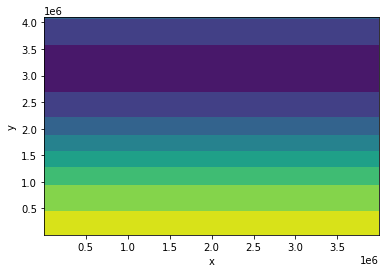

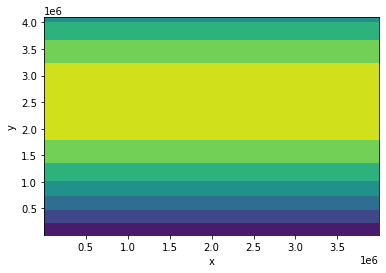

In [79]:
plt.figure()
plt.contourf(X, Y, Qnet)
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.contourf(X, Y, tau_x)
plt.xlabel('x')
plt.ylabel('y')

Text(0.5, 0, 'y')

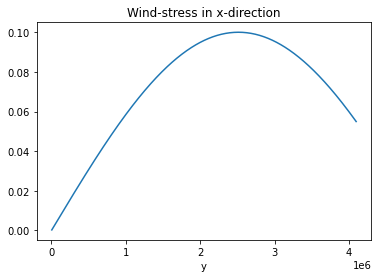

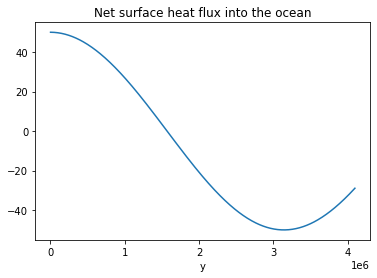

In [80]:
plt.figure()
plt.plot(yt_ocean, tau_x[0, :])
plt.title('Wind-stress in x-direction')
plt.xlabel('y')

plt.figure()
plt.plot(yt_ocean, Qnet[0, :])
plt.title('Net surface heat flux into the ocean')
plt.xlabel('y')

## Equations of Motion

In [81]:
dt = 400
t_start = 0
t_end = 100000
f = f0 + beta_f*Y
um_old = np.zeros((nx, ny))
um_new = np.zeros((nx, ny))
vm_old = np.zeros((nx, ny))
vm_new = np.zeros((nx, ny))
S05_old = np.zeros((nx, ny))
S05_new = np.zeros((nx, ny))
rhom_old = 1025*np.ones((nx, ny))
rhom_new = np.zeros((nx, ny))
hm_new = np.zeros((nx, ny))
hm_old = - MLD_0
eta_old = np.zeros((nx, ny))
eta_new = np.zeros((nx, ny))


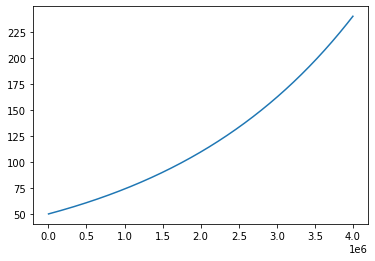

In [70]:
plt.plot(xt_ocean, hm_old[:, 0])

$$ \partial_t h_m  = - \partial_x (u_m h_m) - \partial_y (v_m h_m) -S_{1/2} $$

$$ h_m \partial_t \rho_m + h_m u_m \partial_x \rho_m  + h_m v_m \partial_y \rho_m = -(\rho_{bottom} - \rho_m)S_{1/2} - \alpha Q / c_w$$

$$ ... $$

$$ \partial_y u(x_j, 0) = 0 \to u_{j, 0} = u_{j, 1} $$ 

$$ v(x, 0) = 0 \to v_{i, 0} = 0 $$ 
$$ \partial_x v(0, y) = 0 \to v_{0, j+1} = v_{0, j} $$ 

$$ i=j=0 $$ 
$$ v_{0, 0} = 0 $$

$$ v_{0, 1} = v_{0, 0} = 0$$

In [86]:
def partial_x(f, dx):

    dfdx = 1/(2*dx) * (f[2:nx, 1:ny-1] - f[0:nx-2, 1:ny-1])
    
    return dfdx

def partial_y(f, dy):
    
    dfdx = 1/(2*dy) * (f[1:nx-1, 2:ny] - f[1:nx-1, 0:ny-2])
    
    return dfdx

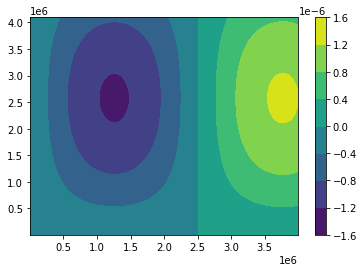

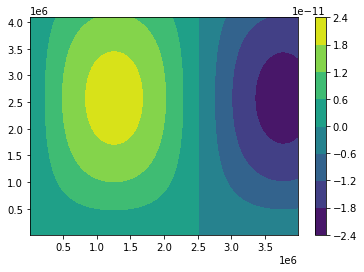

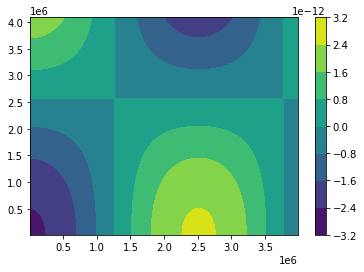

In [87]:
f = np.sin(2.5 * Y/Ly) * np.cos(5 * X/Lx)

dfdx_true = - np.sin(2.5 * Y/Ly) * 5 / Lx * np.sin(5 * X/Lx)
dfdy_true = + 2.5/Ly * np.cos(2.5 * Y/Ly) * np.cos(5 * X/Lx)

plt.figure()
plt.contourf(X, Y, dfdx_true)
plt.colorbar()

dfdx_num = partial_x(f, dx)
dfdy_num = partial_y(f, dy)


plt.figure()
plt.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], dfdx_num-dfdx_true[1:-1, 1:-1])
plt.colorbar()


plt.figure()
plt.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], dfdy_num-dfdy_true[1:-1, 1:-1])
plt.colorbar()


$$ \partial_t h_m  = - \partial_x (u_m h_m) - \partial_y (v_m h_m) -S_{1/2} $$


In [88]:
def enforce_BC(u, v):
    
    # u(0, y) = 0
    u[0, :] = 0
    
    # u(Lx, y) = 0
    u[-1, :] = 0
    
    # v(x, 0) = 0
    v[:, 0] = 0
    
    # v(x, Ly) = 0
    v[:, -1] = 0
    
    #  \partial_x v(0, y) = 0
    v[0, :] = v[1, :]

    #  \partial_x v(Lx, y) = 0
    v[-1, :] = v[-2, :]

    #  \partial_y u(x, 0) = 0
    u[:, 0] = u[:, 1]

    #  \partial_y u(x, Ly) = 0
    u[:, -1] = u[:, -2]

    return u, v

def RHS_hm(um, vm, hm, S05):
    rhs = - partial_x(um * hm) - partial_y(vm * hm) - S05
    return rhs

def Euler_step(hm, um, vm, rhom, S05, dt):
    hm = hm + dt * RHS_hm(um, vm, hm, S05)
    rhom = rhom + dt * RHS_rhom(um, vm, hm, S05)
    um = um + dt * RHS_um(um, vm, hm, S05)
    vm = vm + dt * RHS_vm(um, vm, hm, S05)

In [29]:
%time

for t in np.linspace(0, 10000, int(t_end/dt)+1):
    #Ft = (g/rho0)*((alpha*Qnet/Cp) - rho0*beta*Snet)
    Ft = (g/rho0)*(alpha*Qnet/cp)
    
    if t == 0:
        um_old[0,1:n-1] = 0
        vm_old[0,1:n-1] = vm_old[1,1:n-1]
        um_old[n-1,1:n-1] = 0
        vm_old[n-1,1:n-1] = vm_old[n-1,1:n-1]
        um_old[0:n,0] = um_old[0:n,1]
        vm_old[0:n,0] = 0
        um_old[0:n,n-1] = um_old[0:n,n-1]
        vm_old[0:n,n-1] = 0
    
    
    #Governing Equations
    hm_new[1:n-1,1:n-1] = hm_old[1:n-1,1:n-1] - (
        dt/(2*dx))*(um_old[2:n,1:n-1]*hm_old[2:n,1:n-1] - um_old[0:n-2,1:n-1]*hm_old[0:n-2,1:n-1]) - (
        dt/(2*dy))*(vm_old[1:n-1,2:n]*hm_old[1:n-1,2:n] - vm_old[1:n-1,0:n-2]*hm_old[1:n-1,0:n-2]) - (
        dt*S05_old[1:n-1,1:n-1])
    
    #rhom_new[1:n-1,1:n-1] = rhom_old[1:n-1,1:n-1] - (rho0/(g*hm_old[1:n-1,1:n-1]))*Ft[1:n-1,1:n-1] - (
    #    dt/(2*dx))*(um_old[2:n,1:n-1]*rhom_old[2:n,1:n-1]-um_old[0:n-2,1:n-1]*rhom_old[0:n-2,1:n-1])-(
    #    dt/(2*dy))*(vm_old[1:n-1,2:n]*rhom_old[1:n-1,2:n]-vm_old[1:n-1,0:n-2]*rhom_old[1:n-1,0:n-2])
   

    rhom_new[1:n-1,1:n-1] = rhom_old[1:n-1,1:n-1] - (rho0/(g*hm_old[1:n-1,1:n-1]))*Ft[1:n-1,1:n-1] - (
        dt/(2*dx))*um_old[1:n-1,1:n-1]*(rhom_old[2:n,1:n-1]-rhom_old[0:n-2,1:n-1])-(
        dt/(2*dy))*vm_old[1:n-1,1:n-1]*(rhom_old[1:n-1,2:n]-rhom_old[1:n-1,0:n-2])
    
    #um_new[1:n-1,1:n-1] = um_old[1:n-1,1:n-1] - (
    #    dt/(2*dx))*(um_old[2:n,1:n-1]*um_old[2:n,1:n-1] - um_old[0:n-2,1:n-1]*um_old[0:n-2,1:n-1]) - (
    #    dt/(2*dy))*(um_old[1:n-1,2:n]*vm_old[1:n-1,2:n] - um_old[1:n-1,0:n-2]*vm_old[1:n-1,0:n-2]) + (
    #    dt*f[1:n-1,1:n-1]*vm_old[1:n-1,1:n-1]) - (
    #    (g*hm_old[1:n-1,1:n-1])/(2*rho0))*((dt/(2*dx))*(rhom_old[2:n,1:n-1]-rhom_old[0:n-2,1:n-1])) - (
    #    (g*rhom_old[1:n-1,1:n-1])/rho0)*((dt/(2*dx))*(eta_old[2:n,1:n-1]-eta_old[0:n-2,1:n-1])) + (
    #    dt*tau_x[1:n-1,1:n-1])/(rho0*hm_old[1:n-1,1:n-1])
    
    um_new[1:n-1,1:n-1] = um_old[1:n-1,1:n-1] - (
        dt/(2*dx))*um_old[1:n-1,1:n-1]*(um_old[2:n,1:n-1] - um_old[0:n-2,1:n-1]) - (
        dt/(2*dy))*vm_old[1:n-1,1:n-1]*(um_old[1:n-1,2:n] - um_old[1:n-1,0:n-2]) + (
        dt*f[1:n-1,1:n-1]*vm_old[1:n-1,1:n-1]) - (
        (g*hm_old[1:n-1,1:n-1])/(2*rho0))*((dt/(2*dx))*(rhom_old[2:n,1:n-1]-rhom_old[0:n-2,1:n-1])) - (
        (g*rhom_old[1:n-1,1:n-1])/rho0)*((dt/(2*dx))*(eta_old[2:n,1:n-1]-eta_old[0:n-2,1:n-1])) + (
        dt*tau_x[1:n-1,1:n-1])/(rho0*hm_old[1:n-1,1:n-1])
    
    #vm_new[1:n-1,1:n-1] = vm_old[1:n-1,1:n-1] - (
    #    dt/(2*dx))*(um_old[2:n,1:n-1]*vm_old[2:n,1:n-1] - um_old[0:n-2,1:n-1]*vm_old[0:n-2,1:n-1]) - (
    #    dt/(2*dy))*(vm_old[1:n-1,2:n]*vm_old[1:n-1,2:n] - vm_old[1:n-1,0:n-2]*vm_old[1:n-1,0:n-2]) - (
    #    f[1:n-1,1:n-1]*dt*um_old[1:n-1,1:n-1]) - (
    #    (g*hm_old[1:n-1,1:n-1])/(2*rho0))*((dt/(2*dy))*(rhom_old[1:n-1,2:n]-rhom_old[1:n-1,0:n-2])) - (
    #    (g*rhom_old[1:n-1,1:n-1])/rho0)*((dt/(2*dy))*(eta_old[1:n-1,2:n]-eta_old[1:n-1,0:n-2])) + (
    #    dt*tau_y[1:n-1,1:n-1])/(rho0*hm_old[1:n-1,1:n-1])
    
    vm_new[1:n-1,1:n-1] = vm_old[1:n-1,1:n-1] - (
        dt/(2*dx))*um_old[1:n-1,1:n-1]*(vm_old[2:n,1:n-1] - vm_old[0:n-2,1:n-1]) - (
        dt/(2*dy))*vm_old[1:n-1,1:n-1]*(vm_old[1:n-1,2:n] - vm_old[1:n-1,0:n-2]) - (
        f[1:n-1,1:n-1]*dt*um_old[1:n-1,1:n-1]) - (
        (g*hm_old[1:n-1,1:n-1])/(2*rho0))*((dt/(2*dy))*(rhom_old[1:n-1,2:n]-rhom_old[1:n-1,0:n-2])) - (
        (g*rhom_old[1:n-1,1:n-1])/rho0)*((dt/(2*dy))*(eta_old[1:n-1,2:n]-eta_old[1:n-1,0:n-2])) + (
        dt*tau_y[1:n-1,1:n-1])/(rho0*hm_old[1:n-1,1:n-1])
    
    #Boundary Conditions (I still need to think more about the 4 corner points for hm and rhom)
    um_new[0,1:n] = 0
    vm_new[0,1:n-1] = vm_new[1,1:n-1]
    um_new[n-1,0:n] = 0
    vm_new[n-1,1:n-1] = vm_new[n-1,1:n-1]
    um_new[1:n-1,0] = um_new[1:n-1,1]
    vm_new[0:n,0] = 0
    um_new[1:n-1,n-1] = um_new[1:n-1,n-1]
    vm_new[0:n,n-1] = 0
    
    hm_new[0,1:n-1] = hm_old[0,1:n-1] - (dt*S05_old[0,1:n-1]) - vm_old[0,1:n-1]*(
        dt/(2*dy))*(hm_old[0,2:n] - hm_old[0,0:n-2]) - hm_old[0,1:n-1]*(
        dt/(2*dy))*(vm_old[0,2:n] - vm_old[0,0:n-2]) - hm_old[0,1:n-1]*(
        dt/(2*dx))*(-3*um_old[0,1:n-1] + 4*um_old[1,1:n-1] - um_old[2,1:n-1])
    hm_new[n-1,1:n-1] = hm_old[n-1,1:n-1] - (dt*S05_old[n-1,1:n-1]) - vm_old[n-1,1:n-1]*(
        dt/(2*dy))*(hm_old[n-1,2:n] - hm_old[n-1,0:n-2]) - hm_old[n-1,1:n-1]*(
        dt/(2*dy))*(vm_old[n-1,2:n] - vm_old[n-1,0:n-2]) - hm_old[n-1,1:n-1]*(
        dt/(2*dx))*(3*um_old[n-1,1:n-1] - 4*um_old[n-2,1:n-1] + um_old[n-3,1:n-1])
    hm_new[1:n-1,0] = hm_old[1:n-1,0] - (dt*S05_old[1:n-1,0]) - um_old[1:n-1,0]*(
        dt/(2*dx))*(hm_old[2:n,0] - hm_old[0:n-2,0]) - hm_old[1:n-1,0]*(
        dt/(2*dx))*(um_old[2:n,0] - um_old[0:n-2,0]) - hm_old[1:n-1,0]*(
        dt/(2*dy))*(-3*um_old[1:n-1,0] + 4*um_old[1:n-1,1] - um_old[1:n-1,2])
    hm_new[1:n-1,n-1] = hm_old[1:n-1,n-1] - (dt*S05_old[1:n-1,n-1]) - um_old[1:n-1,n-1]*(
        dt/(2*dx))*(hm_old[2:n,n-1] - hm_old[0:n-2,n-1]) - hm_old[1:n-1,n-1]*(
        dt/(2*dx))*(um_old[2:n,n-1] - um_old[0:n-2,n-1]) - hm_old[1:n-1,n-1]*(
        dt/(2*dy))*(3*vm_old[1:n-1,n-1] - 4*vm_old[1:n-1,n-2] + vm_old[1:n-1,n-3])
    
    #Need to change boundary conditions too!!!
    #rhom_new[0,1:n-1] = rhom_old[0,1:n-1] - ((dt*alpha*Qnet[0,1:n-1])/(cp*hm_old[0,1:n-1])) - (
    #    dt/(2*dx))*(rhom_old[0,1:n-1])*(-3*um_old[0,1:n-1] + 4*um_old[1,1:n-1] - um_old[2,1:n-1]) - (
    #    dt/(2*dy*hm_old[0,1:n-1]))*(rhom_old[0,2:n]*vm_old[0,2:n]*hm_old[0,2:n] - 
    #                                 rhom_old[0,0:n-2]*vm_old[0,0:n-2]*hm_old[0,0:n-2])
    #rhom_new[n-1,1:n-1] = rhom_old[n-1,1:n-1] - ((dt*alpha*Qnet[n-1,1:n-1])/(cp*hm_old[n-1,1:n-1])) - (
    #    dt/(2*dx))*(rhom_old[n-1,1:n-1])*(3*um_old[n-1,1:n-1] - 4*um_old[n-2,1:n-1] + um_old[n-3,1:n-1])- (
    #    dt/(2*dy*hm_old[n-1,1:n-1]))*(rhom_old[n-1,2:n]*vm_old[n-1,2:n]*hm_old[n-1,2:n] - 
    #                                    rhom_old[n-1,0:n-2]*vm_old[n-1,0:n-2]*hm_old[n-1,0:n-2])
    #rhom_new[1:n-1,n-1] = rhom_old[1:n-1,n-1] - ((dt*alpha*Qnet[1:n-1,n-1])/(cp*hm_old[1:n-1,n-1])) - (
    #    dt/(2*dy))*(rhom_old[1:n-1,n-1])*(3*vm_old[1:n-1,n-1] - 4*vm_old[1:n-1,n-2] + vm_old[1:n-1,n-3])- (
    #    dt/(2*dx*hm_old[1:n-1,n-1]))*(rhom_old[2:n,n-1]*um_old[2:n,n-1]*hm_old[2:n,n-1] - 
    #                                    rhom_old[0:n-2,n-1]*um_old[0:n-2,n-1]*hm_old[0:n-2,n-1])
    #rhom_new[1:n-1,0] = rhom_old[1:n-1,0] - ((dt*alpha*Qnet[1:n-1,0])/(cp*hm_old[1:n-1,0])) - (
    #    dt/(2*dy))*(rhom_old[1:n-1,0])*(-3*vm_old[1:n-1,0] + 4*vm_old[1:n-1,1] - vm_old[1:n-1,2]) - (
    #    dt/(2*dx*hm_old[1:n-1,0]))*(rhom_old[2:n,0]*um_old[2:n,0]*hm_old[2:n,0] - 
    #                                 rhom_old[0:n-2,0]*um_old[0:n-2,0]*hm_old[0:n-2,0])
    
    rhom_new[0,1:n-1] = rhom_old[0,1:n-1] - ((dt*alpha*Qnet[0,1:n-1])/(cp*hm_old[0,1:n-1])) - (
        dt/(2*dy))*(rhom_old[0,2:n] - rhom_old[0,0:n-2])
    rhom_new[n-1,1:n-1] = rhom_old[n-1,1:n-1] - ((dt*alpha*Qnet[n-1,1:n-1])/(cp*hm_old[n-1,1:n-1])) - (
        dt/(2*dy))*(rhom_old[n-1,2:n] - rhom_old[n-1,0:n-2])
    rhom_new[1:n-1,n-1] = rhom_old[1:n-1,n-1] - ((dt*alpha*Qnet[1:n-1,n-1])/(cp*hm_old[1:n-1,n-1])) - (
        dt/(2*dx))*(rhom_old[2:n,n-1] - rhom_old[0:n-2,n-1])
    rhom_new[1:n-1,0] = rhom_old[1:n-1,0] - ((dt*alpha*Qnet[1:n-1,0])/(cp*hm_old[1:n-1,0])) - (
        dt/(2*dx))*(rhom_old[2:n,0] - rhom_old[0:n-2,0])
                                     
    #Just putting random values for the 4 corner points
    rhom_new[0,0] = rhom_new[0,1]
    rhom_new[n-1,0] = rhom_new[n-1,1]
    rhom_new[0,n-1] = rhom_new[0,n-2]
    rhom_new[n-1,n-1] = rhom_new[n-1,n-2]
    
    hm_new[0,0] = hm_new[0,1]
    hm_new[n-1,0] = hm_new[n-1,1]
    hm_new[0,n-1] = hm_new[0,n-2]
    hm_new[n-1,n-1] = hm_new[n-1,n-2]

    #Updation Equations
    um_old = um_new
    vm_old = vm_new
    rhom_old = rhom_new
    hm_old = hm_new

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


## Postprocessing
1. x-direction velocity is plotted, and three different regimes are visible.
2. Barotropic Streamfunction is calculated (needs more thought) and plotted.

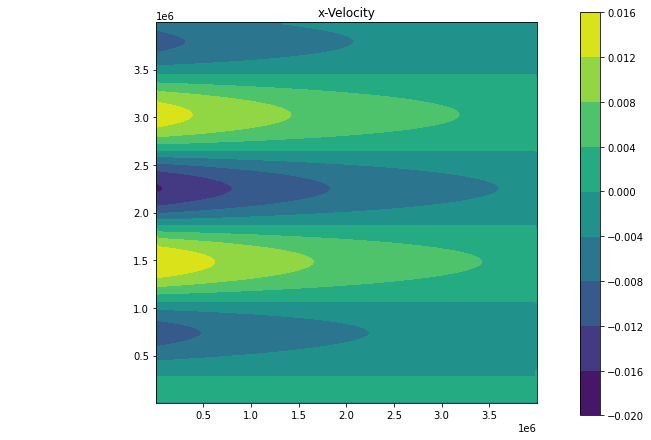

In [30]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('x-Velocity')
#plt.pcolormesh(X, Y, um_new, shading = 'nearest', vmin = -4e-2, vmax = 4e-2)#, cmap = 'Greens')
plt.contourf(X, Y, um_new)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [27]:
#This is correct if we integrate along the western boundary, where u = 0.
psi = np.cumsum(um_new, axis = 1)*(dx/10**6)#*hm_new

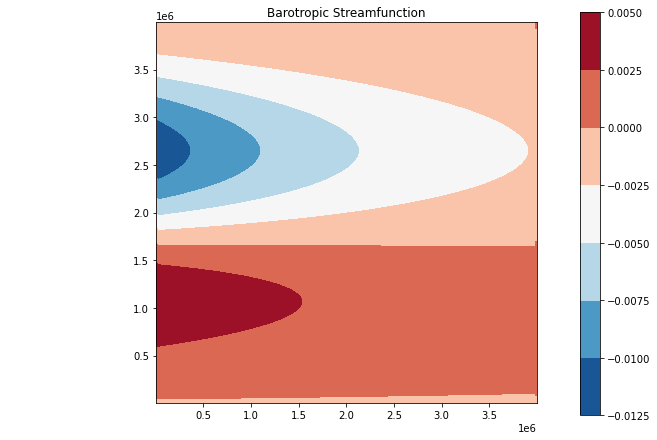

In [28]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('Barotropic Streamfunction')
plt.contourf(X, Y, psi, cmap = 'RdBu_r')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()